In [1]:
#Загружаем библиотеки

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
import seaborn as sns
import os
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Стандартные слои
print ("Ok")

Ok


In [2]:
#Загружаем датафрейм
frame = pd.read_csv('Gosloto_6x45.csv', header=0, sep=';')
frame

,tiraz,datetime,1-number,2-number,3-number,4-number,5-number,6-number
0,1,10.11.2008 08:50,15,17,22,23,25,33
1,2,13.11.2008 08:50,23,29,44,19,24,45
2,3,17.11.2008 08:50,38,7,3,45,26,4
3,4,20.11.2008 08:50,31,26,44,37,40,27
4,5,24.11.2008 08:50,16,17,12,21,23,35
...,...,...,...,...,...,...,...,...
5424,5425,13.10.2020 11:00,18,7,16,23,37,43
5425,5426,13.10.2020 23:00,15,13,35,33,34,28
5426,5427,14.10.2020 11:00,27,44,40,29,41,25
5427,5428,14.10.2020 23:00,1,10,33,37,40,44


In [3]:
# удвляем дату и тираж
frame = frame.drop(columns=['datetime', 'tiraz'], axis=1).astype(float)

<AxesSubplot:>

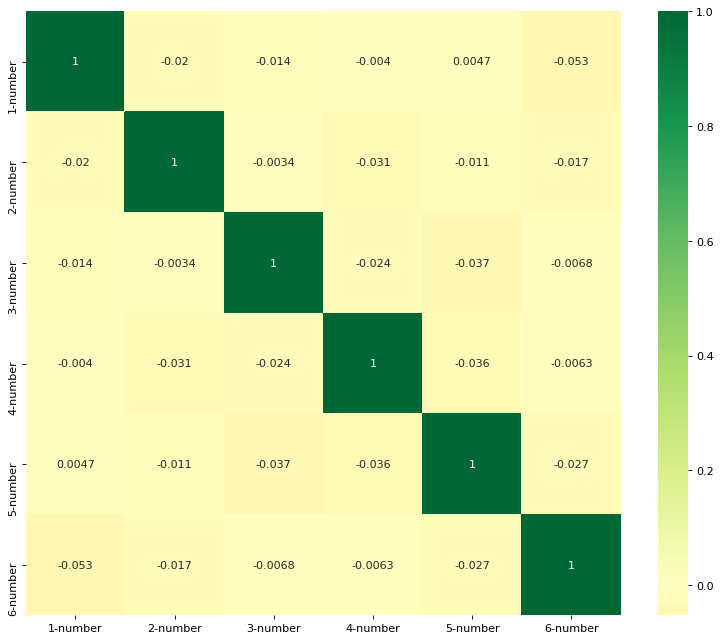

In [4]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(frame.corr(), xticklabels=frame.corr().columns, yticklabels=frame.corr().columns, cmap='RdYlGn', center=0, annot=True)

In [5]:
frame.describe()

,1-number,2-number,3-number,4-number,5-number,6-number
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,22.982133,22.946952,23.113096,22.815620,23.348499,23.023577
std,13.006087,13.174812,12.846011,13.067398,13.046193,12.839588
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000
50%,23.000000,23.000000,23.000000,22.000000,24.000000,23.000000
75%,34.000000,35.000000,34.000000,34.000000,35.000000,34.000000
max,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000


In [6]:
a = frame["1-number"].to_numpy()
b = frame["2-number"].to_numpy()
c = frame["3-number"].to_numpy()
d = frame["4-number"].to_numpy()
e = frame["5-number"].to_numpy()
f = frame["6-number"].to_numpy()
# for numa in a:
#     np.append(allnum, [numa])
con = np.stack([a, b, c,d,e,f], axis=1)
con_r = con.reshape(32574)

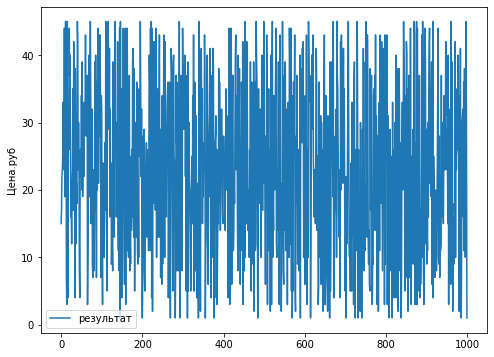

In [7]:
start = 0 #С какой точки начинаем
step = con_r.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
#chanelNames = list(allnum.columns)
plt.plot(con_r[0:1000],
          label="результат")
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. Аргумент history_size — это размер последнего временного интервала, target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

In [8]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [9]:
TRAIN_SPLIT = 30000
#tf.random.set_seed(13)

**Прогнозирование на основе одномерного временного ряда**



In [10]:
con_r = np.array(range(0,60000,1))
#con_r = np.random.randint(0,45,60000)#.reshape(10000,6)

uni_data = con_r
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

# нормализация тензора
#uni_data = tf.keras.utils.normalize(con_r, axis=-1, order=2)

Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться последние 20 зарегистрированных наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге по времени.

In [11]:
univariate_past_history = 50
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

# print ('Single window of past history')
print (x_train_uni[0]*uni_train_std+uni_train_mean)
# print ('\n Target temperature to predict')
print (y_train_uni[0]*uni_train_std+uni_train_mean)

[[ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]
 [ 6.]
 [ 7.]
 [ 8.]
 [ 9.]
 [10.]
 [11.]
 [12.]
 [13.]
 [14.]
 [15.]
 [16.]
 [17.]
 [18.]
 [19.]
 [20.]
 [21.]
 [22.]
 [23.]
 [24.]
 [25.]
 [26.]
 [27.]
 [28.]
 [29.]
 [30.]
 [31.]
 [32.]
 [33.]
 [34.]
 [35.]
 [36.]
 [37.]
 [38.]
 [39.]
 [40.]
 [41.]
 [42.]
 [43.]
 [44.]
 [45.]
 [46.]
 [47.]
 [48.]
 [49.]]
50.0


Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. Передаваемая в ИНС информация выделена синим цветом, красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.


<module 'matplotlib.pyplot' from 'c:\\users\\gryaznevdy\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

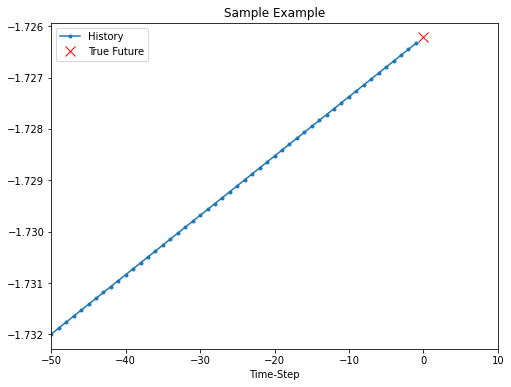

In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Прежде чем приступить к обучению модели, установим простое базовое решение (baseline). Оно заключается в следующем: для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних 20 наблюдений.

-1.729164057183576


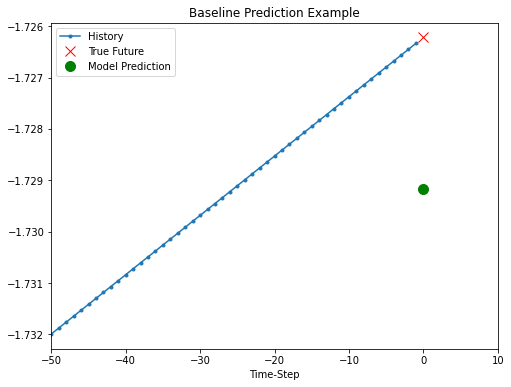

In [13]:

def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
print ( baseline (x_train_uni[0]))

Далее с помощью `[tf.data](https://www.tensorflow.org/api_docs/python/tf/data?hl=ru)` выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.

In [14]:
BATCH_SIZE =1
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

#Убираю шафл!
# train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
# train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [15]:
# simple_lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(10, input_shape=x_train_uni.shape[-2:]),
# 	 tf.keras.layers.Dense(100, activation="linear"),
#     tf.keras.layers.Dense(1)
# ])
# simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(14, 50, input_shape = x_train_uni.shape[-2:], activation="linear"),
	#tf.keras.layers.LSTM(10, input_shape=x_train_uni.shape[-2:].shape[-2:]),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(100, activation="linear"),
    #tf.keras.layers.Dense(1),
	 tf.keras.layers.Dense(1, activation="linear")
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [16]:
EVALUATION_INTERVAL = 1000
EPOCHS = 20
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=1)

Epoch 1/20
1000/1000 [==============================] - 1s 824us/step - loss: 0.0411 - val_loss: 0.3134

In [24]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
x_train_uni.shape

(1, 1)


(29950, 50, 1)

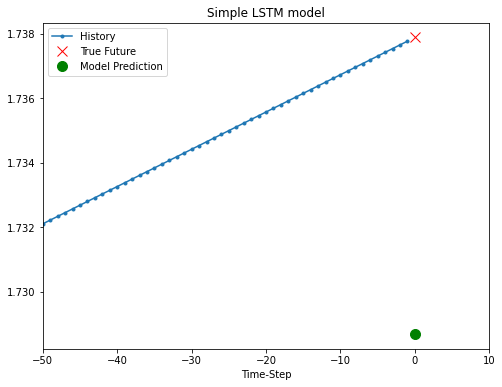

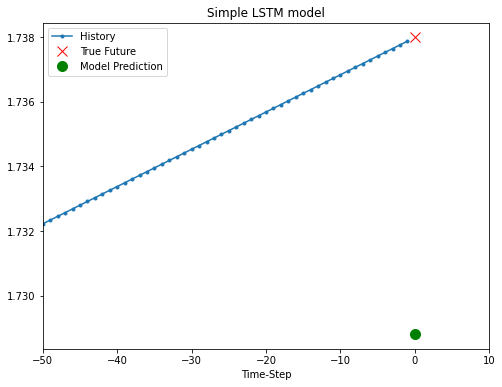

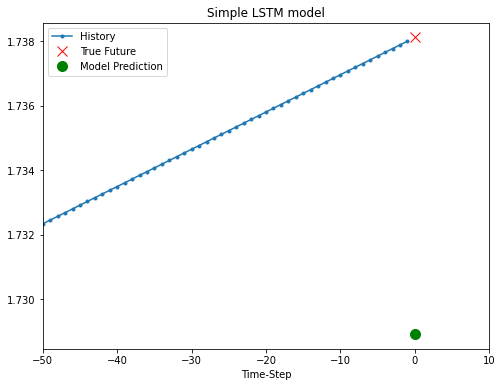

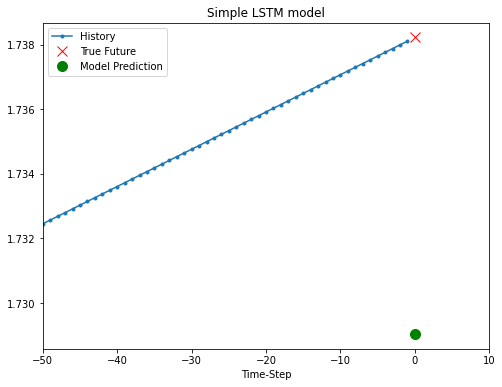

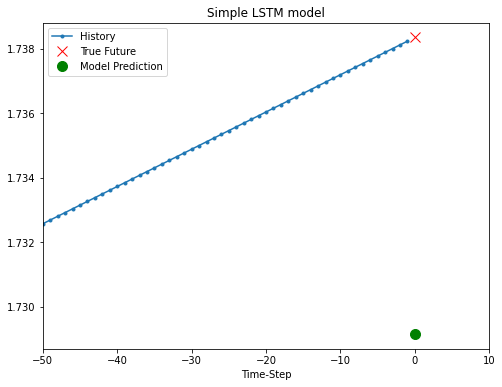

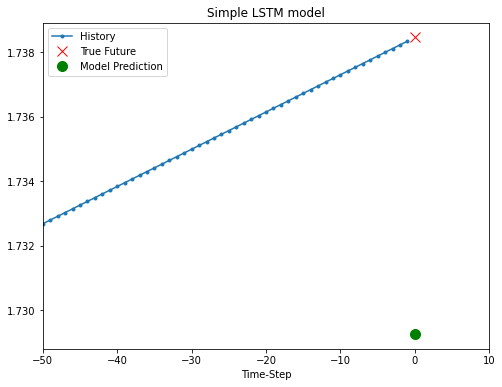

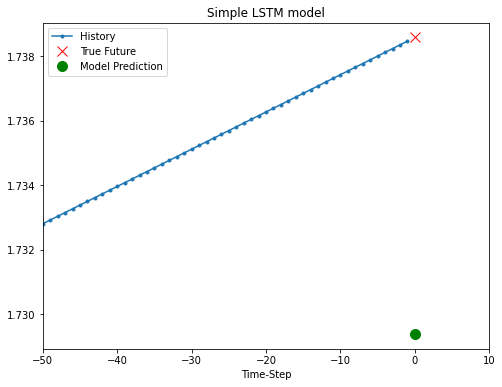

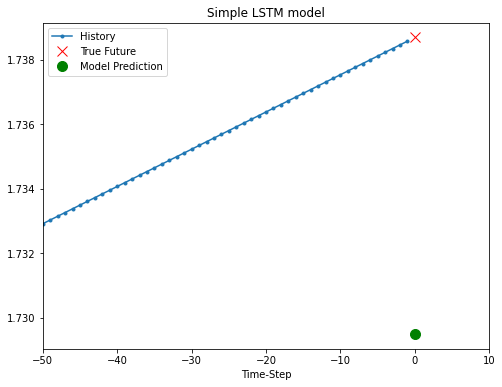

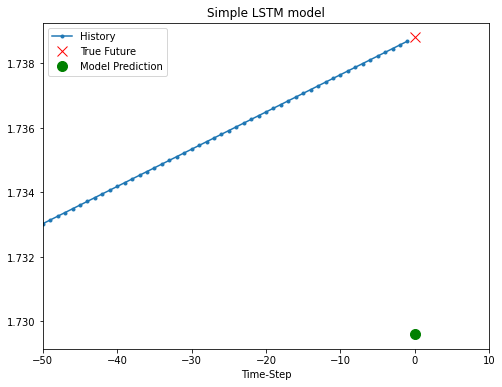

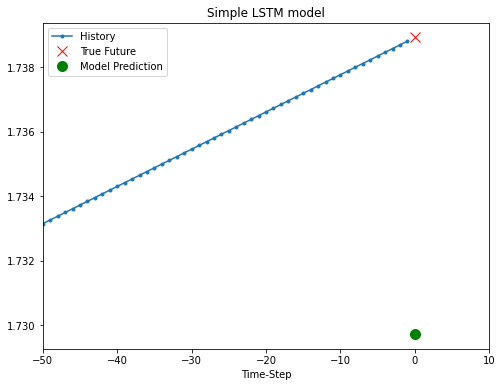

In [18]:
for x, y in val_univariate.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [19]:
print (simple_lstm_model.predict(x)[:10])
for x, y in val_univariate.take(10):
	print (y[0].numpy(),)



[[1.7297273]]
1.7378820462531825
1.7379975163070847
1.7381129863609868
1.7382284564148889
1.738343926468791
1.7384593965226929
1.738574866576595
1.738690336630497
1.7388058066843992
1.7389212767383013


In [20]:
rpred = []
rtarget = []
for x, y in val_univariate.take(50):
	res = y[0].numpy()*uni_train_std+uni_train_mean
	xres = x[0].numpy()*uni_train_std+uni_train_mean
	res2 = (simple_lstm_model.predict(x)[0])*uni_train_std+uni_train_mean
	print (res, res2, res-res2)
	rtarget.append(res)
	rpred.append(res2)
print (rpred)

30050.0 [29970.438] [79.5625]
30051.0 [29971.434] [79.56641]
30052.0 [29972.426] [79.57422]
30053.0 [29973.42] [79.58008]
30054.0 [29974.41] [79.58984]
30055.0 [29975.404] [79.5957]
30056.0 [29976.395] [79.60547]
30057.0 [29977.39] [79.609375]
30058.0 [29978.383] [79.61719]
30059.0 [29979.377] [79.62305]
30060.0 [29980.367] [79.63281]
30061.0 [29981.36] [79.640625]
30062.0 [29982.354] [79.646484]
30063.0 [29983.35] [79.65039]
30064.0 [29984.344] [79.65625]
30065.0 [29985.338] [79.66211]
30066.0 [29986.328] [79.671875]
30067.0 [29987.324] [79.67578]
30068.0 [29988.312] [79.6875]
30069.0 [29989.305] [79.69531]
30070.0 [29990.303] [79.697266]
30071.0 [29991.295] [79.70508]
30072.0 [29992.281] [79.71875]
30073.0 [29993.281] [79.71875]
30074.0 [29994.273] [79.72656]
30075.0 [29995.27] [79.73047]
30076.0 [29996.258] [79.74219]
30077.0 [29997.248] [79.75195]
30078.0 [29998.242] [79.75781]
30079.0 [29999.234] [79.765625]
30080.0 [30000.232] [79.76758]
30081.0 [30001.225] [79.77539]
30082.0 [30

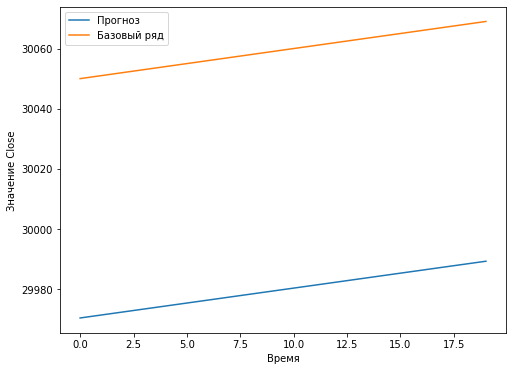

In [21]:
# Попробуем построить график
def showPredict(start, step, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

showPredict(0, 20, rpred, rtarget)
